In [1]:
"""
r: Zongyi Li and Daniel Zhengyu Huang
"""

import numpy
import torch.nn.functional as F
import matplotlib.pyplot as plt
from timeit import default_timer
from catheter import *
from utilities3 import *
from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device is ", (device))

device is  cuda


In [2]:
def Lx2length(L_x, L_p, x1, x2, x3, h):
    l0, l1, l2, l3 = -x3, torch.sqrt((x2-x3)**2 + h**2), torch.sqrt((x1-x2)**2 + h**2), L_p+x1
    if L_x < -x3:
        l = L_x
    elif L_x < -x2:
        l = l0 + l1*(L_x + x3)/(x3-x2)
    elif L_x < -x1:
        l = l0 + l1 + l2*(L_x + x2)/(x2-x1)
    else:
        l = l0 + l1 + l2 + L_x+x1

    return l

def d2xy(d, L_p, x1, x2, x3, h):
    
    p0, p1, p2, p3 = torch.tensor([0.0,0.0]), torch.tensor([x3,0.0]), torch.tensor([x2, h]), torch.tensor([x1,0.0])
    v0, v1, v2, v3 = torch.tensor([x3-0,0.0]), torch.tensor([x2-x3,h]), torch.tensor([x1-x2,-h]), torch.tensor([-L_p-x1,0.0])
    l0, l1, l2, l3 = -x3, torch.sqrt((x2-x3)**2 + h**2), torch.sqrt((x1-x2)**2 + h**2), L_p+x1
    
    xx, yy = torch.zeros(d.shape), torch.zeros(d.shape)
    ind = (d < l0)
    xx[ind] = d[ind]*v0[0]/l0 + p0[0]
    yy[ind] = d[ind]*v0[1]/l0 + p0[1]
    
    ind = torch.logical_and(d < l0 + l1, d>=l0)
    xx[ind] = (d[ind]-l0)*v1[0]/l1 + p1[0] 
    yy[ind] = (d[ind]-l0)*v1[1]/l1 + p1[1]
    
    ind = torch.logical_and(d < l0 + l1 + l2, d>=l0 + l1)
    xx[ind] = (d[ind]-l0-l1)*v2[0]/l2 + p2[0]
    yy[ind] = (d[ind]-l0-l1)*v2[1]/l2 + p2[1]
    
    ind = (d>=l0 + l1 + l2)
    xx[ind] = (d[ind]-l0-l1-l2)*v3[0]/l3 + p3[0]
    yy[ind] = (d[ind]-l0-l1-l2)*v3[1]/l3 + p3[1]
    

    return xx, yy

def catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s):
    x1 = -0.5*L_p
    # ncy = 20
    
    n_periods = torch.floor(L_x / L_p)
    L_x_last_period = L_x - n_periods*L_p
    L_p_s = ((x1 + L_p) + (0 - x3) + torch.sqrt((x2 - x1)**2 + h**2) + torch.sqrt((x3 - x2)**2 + h**2))
    L_s = L_p_s*n_periods + Lx2length(L_x_last_period, L_p, x1, x2, x3, h)
    
    # from 0
    d_arr = torch.linspace(0, 1, N_s) * L_s
    
    # TODO do not compute gradient for floor
    period_arr = torch.floor(d_arr / L_p_s).detach()
    d_arr -= period_arr * L_p_s

    
    xx, yy = d2xy(d_arr, L_p, x1, x2, x3, h)
        
    xx = xx - period_arr*L_p
    
    
    X_Y = torch.zeros((1, N_s, 2), dtype=torch.float).to(device)
    X_Y[0, :, 0], X_Y[0, :, 1] = xx, yy
    return X_Y, xx, yy




1d X error =  0.0011473626207233476
1d Y error =  0.0008794100001069905


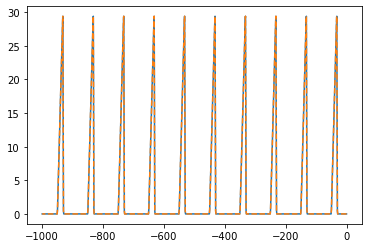

In [3]:
L_x, L_p, x2, x3, h = 1000, 100, -32, -30, 30
x1 = -0.5*L_p
N_s = 1001
X0,Y0 = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x2, x3, h, N_s)

L_p, x2, x3, h =  torch.tensor(L_p, dtype=torch.float), torch.tensor(x2, dtype=torch.float), torch.tensor(x3, dtype=torch.float), torch.tensor(h, dtype=torch.float)
X_Y, X, Y = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)



print("1d X error = ", np.linalg.norm(X0 - X.cpu().numpy()))
print("1d Y error = ", np.linalg.norm(Y0 - Y.cpu().numpy()))
X_Y_numpy = X_Y.cpu().numpy()
plt.plot(X0, Y0)
plt.plot(X_Y_numpy[0, :, 0], X_Y_numpy[0, :, 1], "--")

# ##################################################
# # Prediction on a special design
# #################################################
# model = torch.load("catheter_plain_period_model_1d500", map_location=device)
# out = torch.clip(model(X_Y).squeeze(), min=0.0).detach().cpu().numpy()
# xx_mask = numpy.linspace(1.0, 0, n_periods*ncx+1) * (-L_p*n_periods)
# print("L_p, x1, x2, x3, h  = ", L_p, x1, x2, x3, h)
# print("loss = ",  -np.dot(out,xx_mask) )
# plt.figure()
# plt.plot(xx_mask, out)


[633.           5.04531     66.47064381 -33.2353219  -19.95194009
 -18.2054513   28.37515941]
sample =  633.0
min loss =  270201.4345117723 L_p, x2, x3, h =  tensor(66.4706) tensor(-19.9519) tensor(-18.2055) tensor(28.3752)
predicted loss:  373497.7572783176
-103296.32276654524
0.49975012493753124


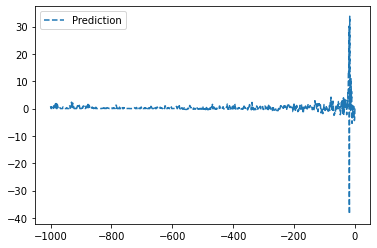

In [4]:
# All data design results
PATH = "/groups/esm/dzhuang/Catheter/allparam/length/"
INPUT_X = PATH+"x_1d_structured_mesh.npy"
INPUT_Y = PATH+"y_1d_structured_mesh.npy"
INPUT_para = PATH+"data_info.npy"
OUTPUT = PATH+"density_1d_data.npy"
inputX_raw = np.load(INPUT_X)
inputY_raw = np.load(INPUT_Y)
inputPara_raw = np.load(INPUT_para)
output_raw = np.load(OUTPUT)


# nx ny
L_x , N_s = 1000.0, 2001

################################################################
# load data and data normalization
################################################################
inputX = inputX_raw[:, 0::3]
inputY = inputY_raw[:, 0::3]
inputPara = inputPara_raw[:, 0::3]
output = (output_raw[:, 0::3] + output_raw[:, 1::3] + output_raw[:, 2::3])/ 3.0


n_data = inputX.shape[1]
all_loss = np.zeros(n_data)


for i in range(n_data):
    
    sample, uf, L_p, x1, x2, x3, h = inputPara[:, i]
    xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
    all_loss[i] = -np.dot(output[:, i], xx_mask) * L_x/N_s

    

loss_min_ind = np.argmin(all_loss)
loss_min = all_loss[loss_min_ind]
sample, uf, L_p, x1, x2, x3, h = inputPara[:, loss_min_ind]

model = torch.load("catheter_plain_length_model_1d500", map_location=device)
L_p, x2, x3, h =  torch.tensor(L_p, dtype=torch.float), torch.tensor(x2, dtype=torch.float), torch.tensor(x3, dtype=torch.float), torch.tensor(h, dtype=torch.float)

X_Y, X, Y = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
out = torch.clip(model(X_Y).squeeze(), min=0.0).detach().cpu().numpy()


print(inputPara[:, loss_min_ind])
print("sample = ", sample)
print("min loss = ", loss_min, "L_p, x2, x3, h = ", L_p, x2, x3, h)

xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
print("predicted loss: ", -np.dot(out, xx_mask) * L_x/N_s)

density = output[:, loss_min_ind]
mesh_X = inputX[:, loss_min_ind]
mesh_Y = inputY[:, loss_min_ind]
plt.figure()
# plt.plot(xx_mask, density, label="Reference")
plt.plot(xx_mask, out - density, "--", label="Prediction")
# plt.plot(mesh_X, mesh_Y)
plt.legend()

print(np.dot(out - density, xx_mask) * L_x/N_s)
print(L_x/N_s)

1336001
initialize :  (tensor(100., grad_fn=<AddBackward0>), tensor(-50., grad_fn=<MulBackward0>), tensor(-30., grad_fn=<AddBackward0>), tensor(-30., grad_fn=<AddBackward0>), tensor(25., grad_fn=<AddBackward0>))
0 0.01863940805196762 loss =  534791.375
L_p, x1, x2, x3, h  =  100.0 -50.0 -30.0 -30.0 25.0


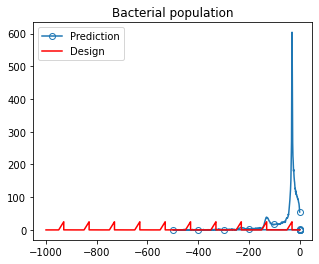

200 0.020373528823256493 loss =  479202.875
L_p, x1, x2, x3, h  =  91.57101440429688 -45.78550720214844 -22.9453067779541 -26.366661071777344 25.723934173583984


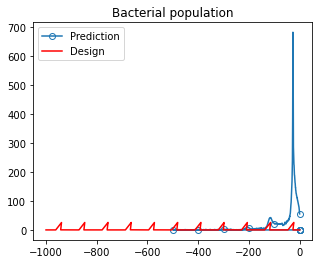

400 0.010329691227525473 loss =  442288.3125
L_p, x1, x2, x3, h  =  84.39739227294922 -42.19869613647461 -17.1275577545166 -23.499794006347656 26.45391082763672


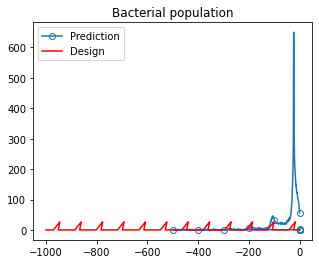

600 0.022634807974100113 loss =  415852.53125
L_p, x1, x2, x3, h  =  78.59687805175781 -39.298439025878906 -13.121326446533203 -21.591838836669922 27.078428268432617


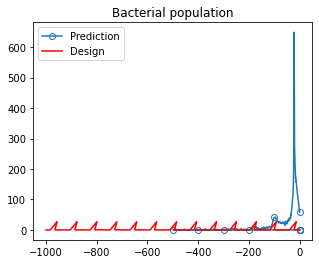

800 0.01030650781467557 loss =  337868.03125
L_p, x1, x2, x3, h  =  73.99967193603516 -36.99983596801758 -10.030170440673828 -19.929428100585938 27.587867736816406


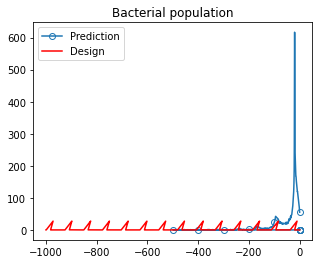

1000 0.010198527947068214 loss =  355078.21875
L_p, x1, x2, x3, h  =  70.72200775146484 -35.36100387573242 -7.545019149780273 -18.52571678161621 28.002044677734375


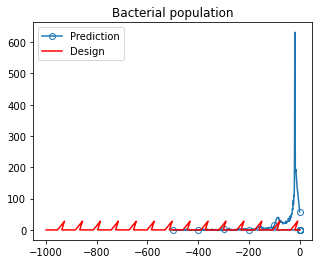

1200 0.010141043923795223 loss =  359651.125
L_p, x1, x2, x3, h  =  70.49386596679688 -35.24693298339844 -7.354734420776367 -18.434534072875977 28.03987693786621


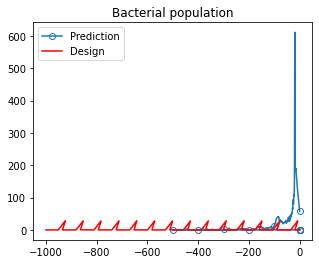

1400 0.010135990101844072 loss =  362621.96875
L_p, x1, x2, x3, h  =  70.31280517578125 -35.156402587890625 -7.17979621887207 -18.36138916015625 28.076732635498047


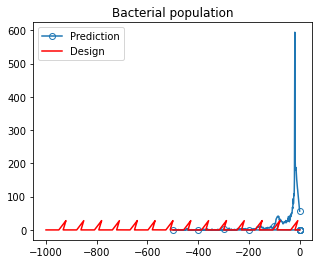

1600 0.010164991021156311 loss =  364919.59375
L_p, x1, x2, x3, h  =  70.15914916992188 -35.07957458496094 -7.019203186035156 -18.300434112548828 28.11251449584961


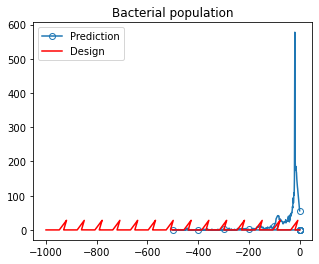

1800 0.010377457365393639 loss =  350443.5625
L_p, x1, x2, x3, h  =  70.00703430175781 -35.003517150878906 -6.868080139160156 -18.242307662963867 28.146991729736328


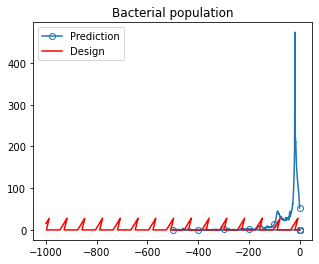

2000 0.010376661084592342 loss =  347994.90625
L_p, x1, x2, x3, h  =  69.81101989746094 -34.90550994873047 -6.714534759521484 -18.16852378845215 28.179798126220703


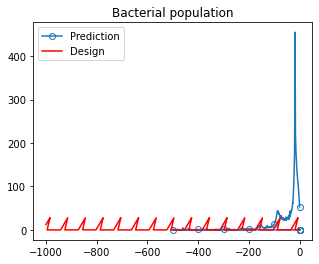

2200 0.010368830990046263 loss =  347655.53125
L_p, x1, x2, x3, h  =  69.78779602050781 -34.893898010253906 -6.69880485534668 -18.159809112548828 28.1829833984375


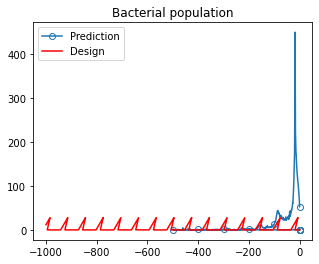

2400 0.010400584898889065 loss =  347368.6875
L_p, x1, x2, x3, h  =  69.76242065429688 -34.88121032714844 -6.682737350463867 -18.15022850036621 28.186111450195312


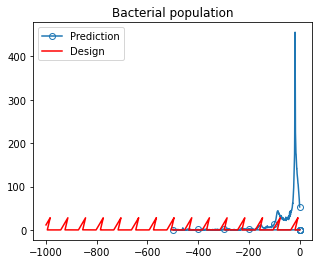

2600 0.010306451003998518 loss =  347092.125
L_p, x1, x2, x3, h  =  69.73641967773438 -34.86820983886719 -6.666681289672852 -18.14035415649414 28.189189910888672


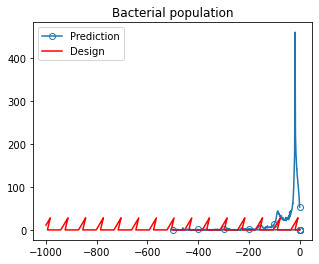

2800 0.01035080011934042 loss =  346833.0
L_p, x1, x2, x3, h  =  69.71046447753906 -34.85523223876953 -6.650783538818359 -18.13048553466797 28.19222640991211


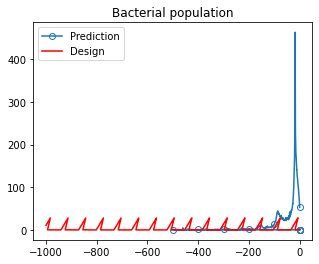

3000 0.010375723708420992 loss =  346565.96875
L_p, x1, x2, x3, h  =  69.6845703125 -34.84228515625 -6.635032653808594 -18.120691299438477 28.195262908935547


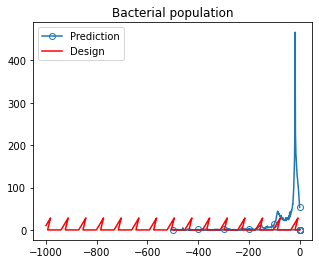

3200 0.010379410348832607 loss =  346541.5
L_p, x1, x2, x3, h  =  69.68194580078125 -34.840972900390625 -6.6334228515625 -18.119707107543945 28.195579528808594


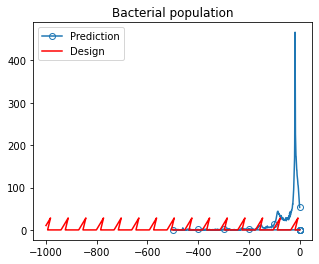

3400 0.010316457133740187 loss =  346524.5625
L_p, x1, x2, x3, h  =  69.67931365966797 -34.839656829833984 -6.63182258605957 -18.11872673034668 28.19589614868164


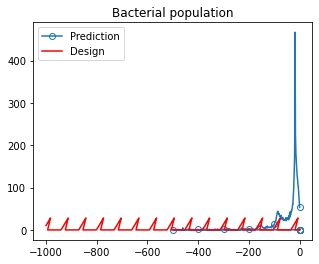

3600 0.010424757841974497 loss =  346507.625
L_p, x1, x2, x3, h  =  69.67668914794922 -34.83834457397461 -6.630224227905273 -18.117753982543945 28.19621467590332


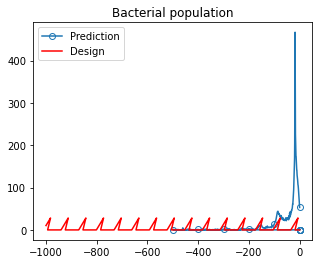

3800 0.010295433923602104 loss =  346496.09375
L_p, x1, x2, x3, h  =  69.67449951171875 -34.837249755859375 -6.628795623779297 -18.116924285888672 28.196531295776367


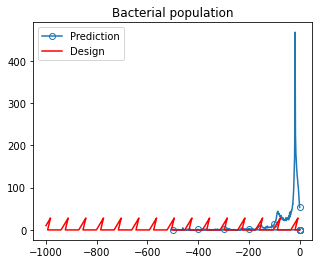

4000 0.010310288984328508 loss =  346480.8125
L_p, x1, x2, x3, h  =  69.67230987548828 -34.83615493774414 -6.627397537231445 -18.116100311279297 28.196849822998047


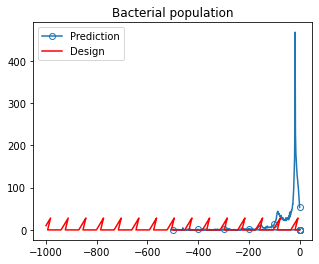

4200 0.010275672655552626 loss =  346477.125
L_p, x1, x2, x3, h  =  69.67186737060547 -34.835933685302734 -6.627195358276367 -18.11594581604004 28.196884155273438


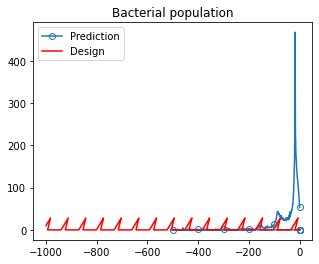

4400 0.010349498130381107 loss =  346474.03125
L_p, x1, x2, x3, h  =  69.67143249511719 -34.835716247558594 -6.626996994018555 -18.115793228149414 28.196918487548828


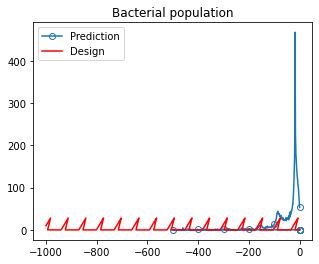

4600 0.010330256074666977 loss =  346470.46875
L_p, x1, x2, x3, h  =  69.6709976196289 -34.83549880981445 -6.626800537109375 -18.11564064025879 28.19695281982422


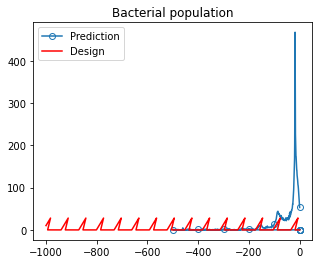

4800 0.010327777825295925 loss =  346466.625
L_p, x1, x2, x3, h  =  69.6705551147461 -34.83527755737305 -6.62660026550293 -18.11548614501953 28.196989059448242


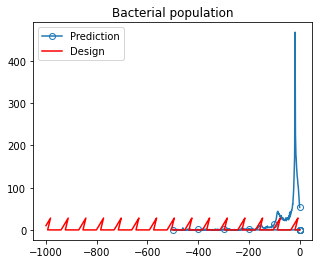

5000 0.010943077970296144 loss =  346463.09375
L_p, x1, x2, x3, h  =  69.67012023925781 -34.835060119628906 -6.626407623291016 -18.11533546447754 28.197025299072266


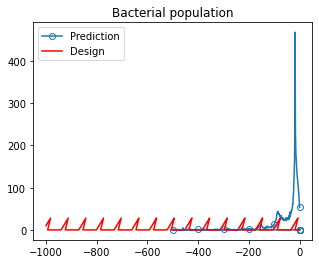

In [19]:
################################################################
# inverse optimization for 1d
################################################################


model = torch.load("catheter_plain_length_model_1d1000", map_location=device)
print(count_params(model))

learning_rate = 0.001
epochs = 5001
step_size = 1000
gamma = 0.1

# learning_rate = 0.001
# epochs = 5001
# step_size = 500
# gamma = 0.5

# constraints   
#               60 < L_p < 250
#               x1 = -0.5L_p 
#               -L_p/4 < x2 - x1 < L_p/4
#               15 < x3 - x1 < L_p/4
#               20 < h < 30
# def transfer(theta):
    
#     L_p = 60 + (250 - 60)/(1 + torch.abs(theta[0]))
#     x1 = -0.5*L_p
#     x2 = x1  - L_p/4 + (L_p/2)/(1 + torch.abs(theta[1]))
#     x3 = x1  + 15 + (L_p/4 - 15)/(1 + torch.abs(theta[2]))
#     h = 20   + (10)/(1 + torch.abs(theta[3]))
#     return L_p, x1, x2, x3, h

# def inv_transfer(L_p, x2, x3, h):
#     x1 = -0.5*L_p
#     theta = np.zeros(4)
#     theta[0] = (250 - 60)/(L_p - 60) - 1
#     theta[1] = (L_p/2)/(x2 - x1  + L_p/4) - 1
#     theta[2] = (L_p/4 - 15)/(x3 - x1  - 15) - 1
#     theta[3] = 10/(h - 20 ) - 1
#     return theta


# constraints   
#               60 < L_p < 250
#               x1 = -0.5L_p 
#               
#               15 < x3 - x1 < L_p/4
#.          -L_p/4 < x2 - x3 < L_p/4
#               20 < h < 30
# def transfer(theta):
def transfer(theta):
    
    L_p = 60 + (250 - 60)/(1 + torch.exp(theta[0]))
    x1 = -0.5*L_p
    x3 = x1  + 15 + (L_p/4 - 15)/(1 + torch.exp(theta[2]))
    x2 = x3  - L_p/4 + (L_p/2)/(1 + torch.exp(theta[1]))
    h = 20   + (10)/(1 + torch.exp(theta[3]))
    return L_p, x1, x2, x3, h


def inv_transfer(L_p, x2, x3, h):
    x1 = -0.5*L_p
    theta = np.zeros(4)
    theta[0] = np.log( (250 - 60)/(L_p - 60) - 1 )
    theta[1] = np.log( (L_p/2)/(x2 - x3  + L_p/4) - 1 )
    theta[2] = np.log( (L_p/4 - 15)/(x3 - x1  - 15) - 1 )
    theta[3] = np.log( 10/(h - 20 ) - 1 )
    return theta

# sample, uf, L_p, x1, x2, x3, h = inputPara[:, loss_min_ind]
# L_p, x2, x3, h = 80.0, -22.0, -22.0, 28.0
L_p, x2, x3, h = 100.0, -30.0, -30.0, 25.0
# L_p, x2, x3, h = 61.0, -30.0, -15.0, 29.0
# x2, x3, h = 73.85438537597656, -9.479606628417969, -19.35201644897461, 27.60188102722168
theta0 =    inv_transfer(L_p, x2, x3, h) 


theta = torch.tensor(theta0.astype(np.float32) , requires_grad=True)
print("initialize : ", transfer(theta))

optimizer = Adam([theta], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)


L_x = 1000
N_s = 2001
xx_mask = (torch.linspace(1.0, 0, N_s) * (-L_x)).to(device)
xx_mask[0:1000] = 0.0
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    
    L_p, x1, x2, x3, h = transfer(theta)
    x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
    
    out = torch.clip(model(x).squeeze(), min=0.0)
    # maximize negative mean
    loss = -torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
    
    loss.backward()
    optimizer.step()
    scheduler.step()

    t2 = default_timer()
    
    if ep%200==0:
        print(ep, t2 - t1,  "loss = ", loss.item())

        mesh = x.detach().cpu().numpy()
        print("L_p, x1, x2, x3, h  = ", L_p.item(), x1.item(), x2.item(), x3.item(), h.item())
        plt.figure(figsize=(5,4))
        plt.title("Bacterial population")
        plt.plot(xx_mask.detach().cpu().numpy(), out.detach().cpu().numpy().T, "-o", fillstyle='none', markevery=len(xx_mask)//10, label="Prediction")
        plt.plot(mesh[0, :, 0], mesh[0, :, 1], color="r", label="Design")
        
        plt.legend()
        plt.show()
#         plt.savefig("Catheter."+str(ep).zfill(5)+".pdf")